<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Erin/Wasted_European_Call_jax_1stock_v3_pricedelta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test (Skip this if not trying to test, to make sure that functions are defined correctly in cells below without running this cell)

In [1]:
# import jax
# import jax.numpy as jnp
# from jax import random
# from jax import jit
# import numpy as np
# from torch.utils.dlpack import from_dlpack

In [2]:
# mylist = []
# for j in range(4):
#   mylist.append(j)

# mylist

In [3]:
# mylist = []
# for j in range(4):
#   mylist.append([j, j+1])

# mylist

In [4]:
# mylist = []
# for j in range(4):
#   mylist_tmp = []
#   for i in range(2):
#     mylist_tmp.append(j+i)
#   mylist.append(mylist_tmp)

# mylist

In [5]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T):
  return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

numstocks = 1
numsteps = 50
numpaths = 1000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.0807]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.2597*0.2597
initial_stocks = jnp.array([0.7178]*numstocks) # must be float
T = 1.0
K = 0.2106

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))
#%timeit optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T)

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T))
#%timeit goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T)

0.5233102
[0.9996969]


# Construct Neural Net

In [6]:
%%writefile cupy_dataset.py
# version 1, 2, 6
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, keys): # need to pass 'keys'
    return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

###################################################################################################
# these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
###################################################################################################

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          rng = jax.random.PRNGKey(self.seed)
          rng, key = jax.random.split(rng)

          ################################################################################################### generate random input numbers

          initial_stocks = jnp.array(0.75 + np.random.random(self.N_STOCKS) * 0.5)

          corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
          sigma = jnp.array(0.15 + np.random.random(self.N_STOCKS) * 0.3)
          cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

          r = jnp.repeat(jnp.array(0.25 + np.random.random(1) * 0.35), self.N_STOCKS)
          drift = r

          T = self.T
          K = 0.75 + np.random.random(1) * 0.5

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas
          
          keys = jax.random.split(key, self.N_PATHS)

          European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'
          gooptionvalue = jax.grad(optionvalueavg, argnums=1)
          Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price
          Y[op, 1:] = cupy.array(Deltas, dtype=cupy.float32) # remember to change this!

          # T, K, S, sigma, mu, r
          paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = OptionDataSet(max_len = 2, number_path = 1000000, batch = 2, seed = np.random.randint(10000), stocks=1) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

Overwriting cupy_dataset.py


In [7]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, 32) # remember to change this!
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1) # 1 outputs: price
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.3, 0.35, 0.35]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.75, 0.15, 0.25, 0.25]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Overwriting model.py


# Train Neural Net

In [8]:
!pip install pytorch-ignite

In [10]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 1000000, batch = 8, seed = np.random.randint(10000), stocks = 1) # must have random seed

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 3]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter) # print by multiplying 10000 -> easier to read (actual loss function isn't amplified)
        
trainer.run(dataset, max_epochs = 100)

loss 0.6531068086624146 average time 0.10094824725019862 iter num 20
loss 0.5204014778137207 average time 0.05834397722483118 iter num 40
loss 0.5402433276176453 average time 0.044020107066595905 iter num 60
loss 0.5824537873268127 average time 0.036989746537528845 iter num 80
loss 0.5137979388237 average time 0.03273940778002725 iter num 100
loss 0.4186602234840393 average time 0.10036550120003085 iter num 20
loss 0.41672831773757935 average time 0.05796865584979969 iter num 40
loss 0.4737706482410431 average time 0.0438817424999191 iter num 60
loss 0.3606874644756317 average time 0.036901925224947264 iter num 80
loss 0.33376845717430115 average time 0.03272845099989354 iter num 100
loss 0.36386844515800476 average time 0.10084672904995387 iter num 20
loss 0.27255499362945557 average time 0.05840950184974645 iter num 40
loss 0.178409606218338 average time 0.044336197383260396 iter num 60
loss 0.2089894860982895 average time 0.03724570077483804 iter num 80
loss 0.17559798061847687 aver

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [13]:
import torch
model_save_name = 'jax_european_1stock_pricedelta_3.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import torch
model_save_name = 'jax_european_1stock_pricedelta_3.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [ ]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

**Continue to train model**

In [20]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed
dataset = OptionDataSet(max_len = 100, number_path = 2000000, batch = 8, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 3]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 10

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter) # print by multiplying 10000 -> easier to read (actual loss function isn't amplified)
        
trainer.run(dataset, max_epochs = 30)

# model_save_name = 'jax_european_1stock_pricedelta_2.pth'
# path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
# torch.save(model.state_dict(), path)

loss 0.012777091935276985 average time 0.6390614108997397 iter num 10
loss 0.03996242210268974 average time 0.3276098110998646 iter num 20
loss 0.03505583852529526 average time 0.22382047176639996 iter num 30
loss 0.003653594059869647 average time 0.17177793257478696 iter num 40
loss 0.006702820770442486 average time 0.14054995393998979 iter num 50
loss 0.015506142750382423 average time 0.11995558269991306 iter num 60
loss 0.015156666748225689 average time 0.10509438035712394 iter num 70
loss 0.008086547255516052 average time 0.09393434113744661 iter num 80
loss 0.00683393981307745 average time 0.08530658661107332 iter num 90
loss 0.007387408055365086 average time 0.07837861602998601 iter num 100
loss 0.014143883250653744 average time 0.34100242049898954 iter num 10
loss 0.00963977724313736 average time 0.17844244629959577 iter num 20
loss 0.007412024773657322 average time 0.12421809286618858 iter num 30
loss 0.010265884920954704 average time 0.09711491717444005 iter num 40
loss 0.0030

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [21]:
model_save_name = 'jax_european_1stock_pricedelta_3.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

#Results

In [22]:
import torch
inputs = torch.tensor([[1, 1, 1, 0.25, 0.3, 0.3]]).cuda() # T, K, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[2]]

# price, delta
# should be around (0.27130044, 0.90763223)

price: tensor([[0.2823]], device='cuda:0', grad_fn=<AddmmBackward>)


tensor([0.9324], device='cuda:0')

In [23]:
numstocks = 1
numsteps = 50
numpaths = 1000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.3]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([1.0]*numstocks) # must be float
T = 1.0
K = 1.0

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T))

0.27089724
[0.90711933]


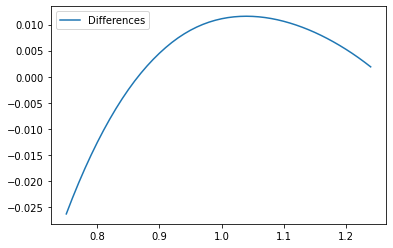

In [24]:
from scipy.stats import norm
from math import log, sqrt, pi, exp
import matplotlib.pyplot as plt

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

def compute_price(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.3, 0.3]]).cuda()
    return model(inputs.float())

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
BS_call_prices = []
for p in prices:
    model_call_prices.append(compute_price(p).item())
    BS_call_prices.append(bs_call(p, 1, 1, 0.3, 0.25))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, BS_call_prices, label = "BS_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(BS_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

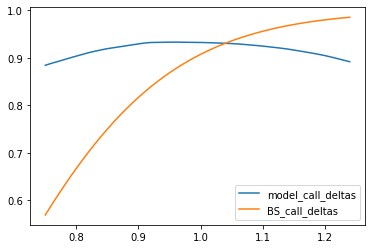

In [25]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.3, 0.3]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1, 1, 0.3, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()